Fit interpretable models to the training set and test on validation sets. Uses imodels package as of 10/25/2020 (v0.2.5).

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
import viz
import pickle as pkl
import matplotlib.pyplot as plt
from os.path import join as oj
import os
import numpy as np
from copy import deepcopy
from dtreeviz.trees import *
import imodels
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.inspection import permutation_importance
import data
from pecarn_predict import pecarn_rule_predict
import validate
outcome_def = 'iai_intervention' # output
MODELS_DIR = '../models/simple_3_splits'
os.makedirs(MODELS_DIR, exist_ok=True)

# Load the data

In [ ]:
# load the data
df_pecarn, df_psrc, common_feats, filtered_feats_pecarn, filtered_feats_psrc = data.load_it_all(dummy=True)
df = df_pecarn[common_feats].append(df_psrc[common_feats])
processed_feats = data.select_final_feats(common_feats)

# split the idxs
train_idxs = df.cv_fold.isin(data.pecarn_train_idxs)
test_idxs1 = df.cv_fold.isin(data.pecarn_test_idxs)
test_idxs2 = df.cv_fold.isin(data.psrc_train_idxs + data.psrc_test_idxs)

# split the data
X, y = df[processed_feats], df[outcome_def]
half = train_idxs.sum() // 2
split_to_plot = '_test2'

# 3-split
X_train, y_train = X[train_idxs], y[train_idxs]
X_cv, y_cv = X_train, y_train
X_test1, y_test1 = X[test_idxs1], y[test_idxs1]

# try loading psrc data
if df_psrc.shape[0] > 0:
    X_test2, y_test2 = X[test_idxs2], y[test_idxs2]
else:
    X_test2, y_test2 = X_test1, y_test1

# look at importances for all the models

In [16]:
try:
    imp_dict = pkl.load(open('../reports/importances.pkl', 'rb'))
    importances = imp_dict['importances']
    fnames = imp_dict['fnames']
except:
    suffix = '_train'
    fnames = []
    importances = []
    for fname in tqdm(sorted(os.listdir(MODELS_DIR))):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf': # and not 'grl' in fname: # and not 'irf' in fname:
                fnames.append(fname[:-4])
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
                threshes = np.array(r['threshes' + suffix])

                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                best_idx = np.argmax(5 * sens + spec)
                m = r['model']
                print(m)

                importances.append(
                    permutation_importance(m, X_train, y_train,
                                           n_repeats=1,
                                           scoring='roc_auc',
                                           random_state=0).importances_mean
                )
    pkl.dump({'importances': importances, 'fnames': fnames}, open('../reports/importances.pkl', 'wb'))            
    imp_dict = pkl.load(open('../reports/importances.pkl', 'rb'))
    importances = imp_dict['importances']
    fnames = imp_dict['fnames']

In [ ]:
# add PECARN importances
# pecarn importances
def m(d):
    low_risk_patients, missed_patients, stats = pecarn_rule_predict(d, print_rule=False)
    return stats['roc_auc']

np.random.seed(0)
imps = []
rocs = []
df_pecarn, df_psrc, common_feats, filtered_feats_pecarn, filtered_feats_psrc = data.load_it_all(dummy=False)
final_feats = data.select_final_feats(common_feats)
final_feats = [feat.replace('GCSScore_Full', 'GCSScore') for feat in final_feats]
for feat in tqdm(final_feats):
    d = deepcopy(df_pecarn)
    d[feat] = np.random.permutation(d[feat])
    rocs.append(m(d))
#     print(feat, rocs[-1])
rocs = m(df_pecarn) - np.array(rocs)    
reorder = np.array([1, 2, 4, 6, 7, 8, 10, 11, 12, 12, 12, 12, 12, 12, 14, 15])
# for i in range(len(final_feats)):
#     print(i, np.array(final_feats)[reorder][i], rocs[reorder][i])
importances = importances + [rocs[reorder]]
fnames += ['PECARN']  

In [17]:
# exclude irf / grl
IDXS_EXCLUDE = [2]
imps = [importances[i] for i in range(len(importances))
        if not i in IDXS_EXCLUDE]
# print(imps)
fnames = [fnames[i] for i in range(len(fnames))
      if not i in IDXS_EXCLUDE]

In [18]:
fnames

['bayesian_rule_list', 'decision_tree', 'irf', 'rulefit']

In [19]:
imps

[array([0.        , 0.13571898, 0.05128907, 0.        , 0.        ,
        0.01033308, 0.14127764, 0.01198009, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00753986,
        0.        ]),
 array([0.00000000e+00, 7.01219746e-02, 9.60413323e-02, 0.00000000e+00,
        0.00000000e+00, 1.15994584e-02, 1.28915003e-01, 6.08532283e-04,
        1.12532988e-02, 0.00000000e+00, 0.00000000e+00, 7.23727301e-03,
        1.75263043e-02, 3.07631981e-02, 0.00000000e+00, 3.83025827e-06]),
 array([0.02864315, 0.14232857, 0.12435652, 0.03305992, 0.04948598,
        0.03603555, 0.14375151, 0.0301245 , 0.03538584, 0.04686991,
        0.06368523, 0.0100482 , 0.01946489, 0.03781518, 0.08815052,
        0.05093047]),
 array([ 0.        ,  0.03761457,  0.06829877,  0.        ,  0.00691888,
         0.        ,  0.09681026,  0.        , -0.00066982,  0.        ,
         0.00845817,  0.        , -0.00033658,  0.        ,  0.00495731,
         0.0063477 ])]

In [21]:
ks = ['AbdDistention_or_AbdomenPain_yes', 'AbdTenderDegree_None',
       'AbdTrauma_or_SeatBeltSign_yes', 'Age<2_yes', 'CostalTender_yes',
       'DecrBreathSound_yes', 'GCSScore_Full_yes', 'Hypotension_yes',
       'MOI_Bike collision/fall', 'MOI_Fall from an elevation',
       'MOI_Motor vehicle collision', 'MOI_Motorcycle/ATV/Scooter collision',
       'MOI_Object struck abdomen',
       'MOI_Pedestrian/bicyclist struck by moving vehicle',
       'ThoracicTrauma_yes', 'VomitWretch_yes']
# ks = list(X.keys())
feat_counts = {k: 0 for k in ks}
feat_sums = {k: 0 for k in ks}
feat_lists = {k: [] for k in ks}
for i in range(len(imps)):
    for j in range(len(feat_counts)):
        if not imps[i][j] <= 0:
            feat_counts[ks[j]] += 1
            feat_sums[ks[j]] += imps[i][j]
            feat_lists[ks[j]] += [fnames[i]]
def sort_by_val(x):
    return {k: v for k, v in sorted(x.items(), key=lambda item: -1 * item[1])}
sort_by_val(feat_counts)

{'AbdTenderDegree_None': 4,
 'AbdTrauma_or_SeatBeltSign_yes': 4,
 'GCSScore_Full_yes': 4,
 'DecrBreathSound_yes': 3,
 'Hypotension_yes': 3,
 'ThoracicTrauma_yes': 3,
 'VomitWretch_yes': 3,
 'CostalTender_yes': 2,
 'MOI_Bike collision/fall': 2,
 'MOI_Motor vehicle collision': 2,
 'MOI_Motorcycle/ATV/Scooter collision': 2,
 'MOI_Object struck abdomen': 2,
 'MOI_Pedestrian/bicyclist struck by moving vehicle': 2,
 'AbdDistention_or_AbdomenPain_yes': 1,
 'Age<2_yes': 1,
 'MOI_Fall from an elevation': 1}

Bayesian rule list
CART decision tree
Iterative random forest
Rule fit


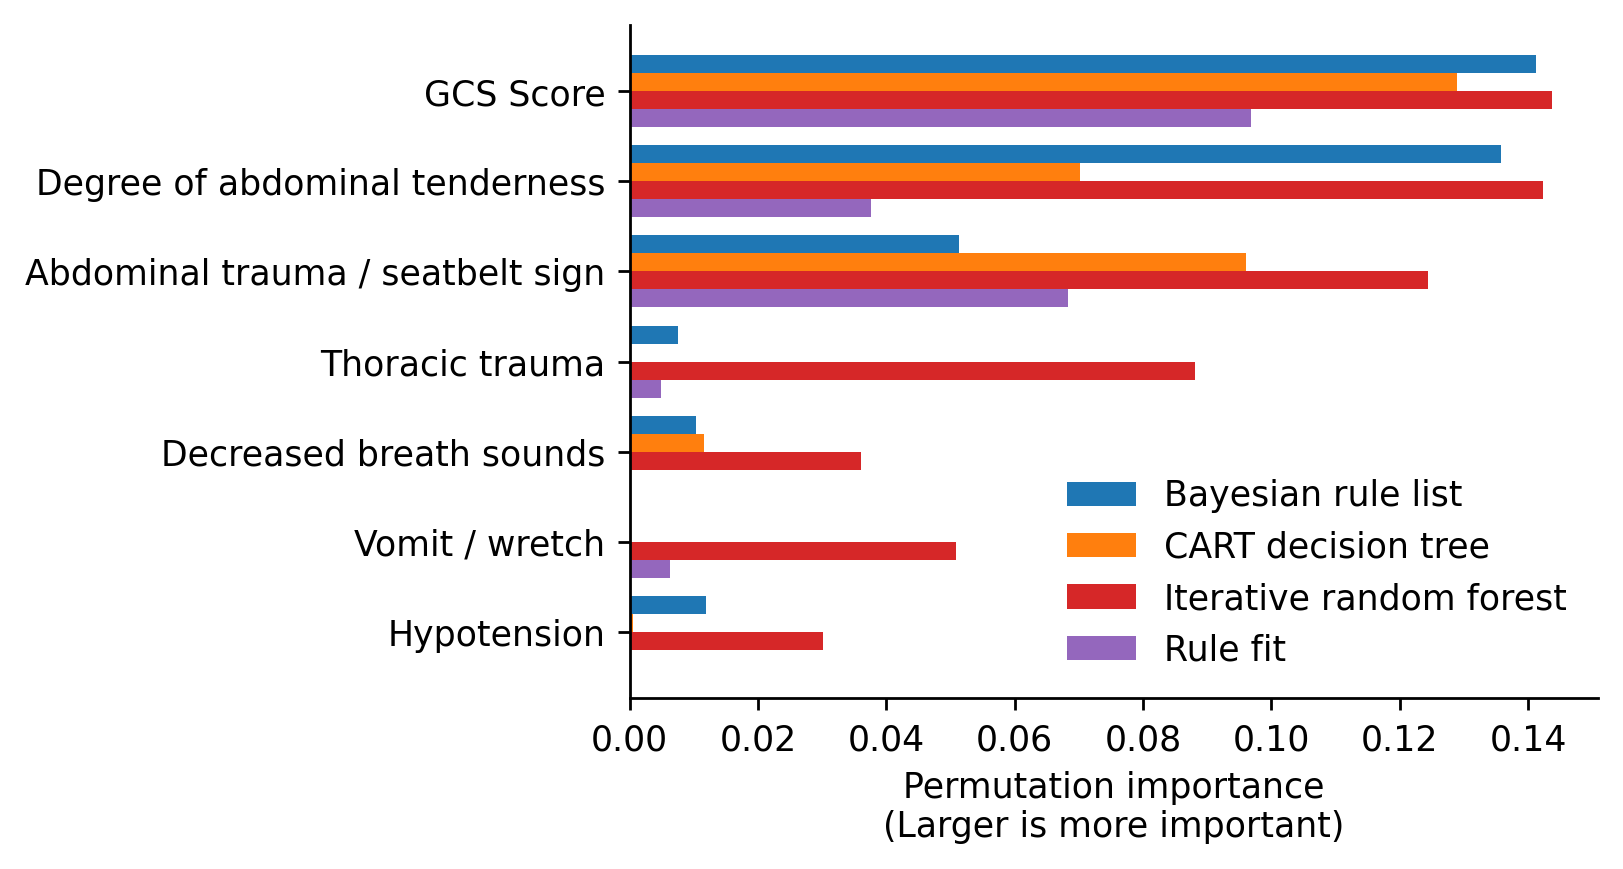

In [25]:
relative_agg_imps = np.fromiter(feat_counts.values(), dtype=int) + np.fromiter(feat_sums.values(), dtype=float)
args = np.argsort(relative_agg_imps)[9:] # exclude features with count of 1
fig, ax = plt.subplots(dpi=250, figsize=(5, 3.5))


ind = np.arange(len(args))
reorder_for_colors = [0, 1, 3]
width = 0.2


cs = {
    'Bayesian rule list': '#1f77b4',
    'CART decision tree': '#ff7f0e',
    'CART rule list': 'green',
    'Iterative random forest': '#d62728',
    'Rule fit': '#9467bd',
    'PECARN': 'black',
}
colors = ['#2ca02c', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

for i in range(len(imps)):
    print(viz.rename(fnames[i]))
    ax.barh(ind - width * i, imps[i][args], width,
            label=viz.rename(fnames[i]),
            color=cs[viz.rename(fnames[i])]
           )
#     ax.barh(ind + width, df.m, width, color='green', label='M')

def rename_local(x):
        rename_map = {
            'GCSScore_Full_yes': 'GCS Score',
            'AbdTenderDegree_None': 'Degree of abdominal tenderness',
            'AbdTrauma_or_SeatBeltSign_yes': 'Abdominal trauma / seatbelt sign',
            'DecrBreathSound_yes': 'Decreased breath sounds',
            'ThoracicTrauma_yes': 'Thoracic trauma',
            'VomitWretch_yes': 'Vomit / wretch'
        }
        if x in rename_map:
            return rename_map[x]
        else:
            return x.replace('_yes', '').replace('_', ' ')

ax.set(yticks=ind - width - width/2,
       yticklabels=[rename_local(lab)
                    for lab in np.array(ks)[args]]) #, ylim=[2*width - 1, len(df)])
# print(ks[args])
ax.legend(frameon=False)
plt.xlabel('Permutation importance\n(Larger is more important)')
plt.show()